In [1]:
def calculateAlpha (ticker, n):

    #from merged prices import data considering  on the ticker 
    #set query
    query = f"""
                SELECT *
                FROM `stockmarket-v0.stockMarket_dev.mergedPrices` as df
                where df.symbol = '{ticker}'
                order by df.date

                """

    #import data 
    df_returns = pd.read_gbq(query= query,
                            project_id=project_id, ).set_index(['symbol', 'date', 'stock_pastdate'])



    #calculate daily returns 
    df_returns['stockReturns'] = df_returns['close'].pct_change()
    df_returns['indexReturns'] = df_returns['indexPrice'].pct_change()

    #calculate rolling correlation between asset and market for the last n days 
    corr_ = df_returns.reset_index()[['stockReturns','indexReturns']].rolling(n).corr()['stockReturns']
    corr_ = corr_.reset_index()
    corr_ = corr_.loc[corr_.level_1 !='stockReturns'].rename(columns = {'stockReturns':'correlation'})
    corr = corr_['correlation']

    #add values to the data 
    df_returns['correlation'] = corr.values
    
    #calculate daily volatility of the last n trading days
    #of the stock  
    df_returns['stdStock'] = df_returns['stockReturns'].rolling(n).std()
    #of the market 
    df_returns['stdIndex']  = df_returns['indexReturns'].rolling(n).std()

    #get price from n days ago - to calculate growth 
    past_close = df_returns['close'].shift(n)
    past_closeIndex = df_returns['indexPrice'].shift(n)

    #calculate returns of the last n trading days 
    stockpastReturns = (df_returns['close'] - past_close) / past_close
    indexpastReturns = (df_returns['indexPrice'] - past_closeIndex) / past_closeIndex
    df_returns['QoQ_stockReturn'] = stockpastReturns
    df_returns['QoQ_indexReturn'] = indexpastReturns
    
    #calculate Beta (correlation * (std(asset)/std(market)))
    
    df_returns['beta'] = df_returns['correlation'] * (df_returns['stdStock'] / df_returns['stdIndex'])
    #calculate alpha
    df_returns['alpha'] = stockpastReturns - (df_returns['beta'] *indexpastReturns )
    return(df_returns.reset_index())


import sys
sys.path.insert(1, r'C:\Users\rafae\Personal\Github\GCP-Stock_Market\FMP_API')
sys.path.insert(2, r'C:\Users\rafae\Personal\Github\GCP-Stock_Market\InsertData')


import pandas as pd


import FMP_API as API
import insertBQ_Class as insert

#set key
key = '54594d7278e0fa3c0831a72c60e04b8d'

#set big query variables
project_id = 'stockmarket-v0'
table_name = 'QuarterlyAlpha'
dataset_name = 'stockMarket_dev'

#set table path
destionation_table_name = f'{project_id}.{dataset_name}.{table_name}'

#get ticker object
tickerAPI = API.getSymbols(key)

#get tickers
tickers = tickerAPI.get_NYSE()

#print general information
print(f'Project ID: {project_id}')
print(f'Dataset Name: {dataset_name}')
print(f'Inserting Data into: {table_name}')

#create an empty df
data = pd.DataFrame()
#for each ticker 
for ticker in tickers[:1]:  
    ticker = 'MSFT'
    try:
        #calculate alpha for n = 63 (quarter)
        data_temp  = calculateAlpha(ticker,63)
        #add to the main dataframe
        data = pd.concat([data,data_temp ],
                        axis=0)
    except Exception as error:
        print(f'Ticker: {ticker}')
        print(error)
        pass
    
#set numberical columns to float
cols = [ 'close', 'indexPrice', 'stockReturns',
       'indexReturns', 'correlation', 'stdStock', 'stdIndex', 'beta', 'alpha',]
data[cols] = data[cols].astype(float)

#set query to check for duplicates
query =  f"""
    SELECT df.symbol,df.date,df.close
    FROM `{destionation_table_name}` as df 
    
    """

#set index for duplicate checking
index_list = ['symbol','date']

# set insert data object
insertBQ = insert.insertData(projectID = project_id,
                            dataset_name = dataset_name,
                            duplicates = False,)

#insert data
# insertBQ.insertData(data = data,
#                     table_name = table_name,
#                     query = query,
#                     index_list = index_list)

Project ID: stockmarket-v0
Dataset Name: stockMarket_dev
Inserting Data into: QuarterlyAlpha


#### Compare Beta calculated using the formula vs using OLS

##### Using Formula

In [9]:
data.iloc[-1]['beta']

1.2370383618570653

##### Using OLS

In [10]:
import statsmodels.api as sm

X = data.indexReturns.iloc[-63:]
y = data.stockReturns.iloc[-63:]

# Add a constant to the independent value
X1 = sm.add_constant(X)

# make regression model 
model = sm.OLS(y, X1)

# fit model and print results
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           stockReturns   R-squared:                       0.475
Model:                            OLS   Adj. R-squared:                  0.466
Method:                 Least Squares   F-statistic:                     55.10
Date:                Fri, 14 Apr 2023   Prob (F-statistic):           4.33e-10
Time:                        16:52:56   Log-Likelihood:                 180.43
No. Observations:                  63   AIC:                            -356.9
Df Residuals:                      61   BIC:                            -352.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0017      0.002      0.979   

### Plot Index Benchmark Price 

Text(0.5, 0, 'Date')

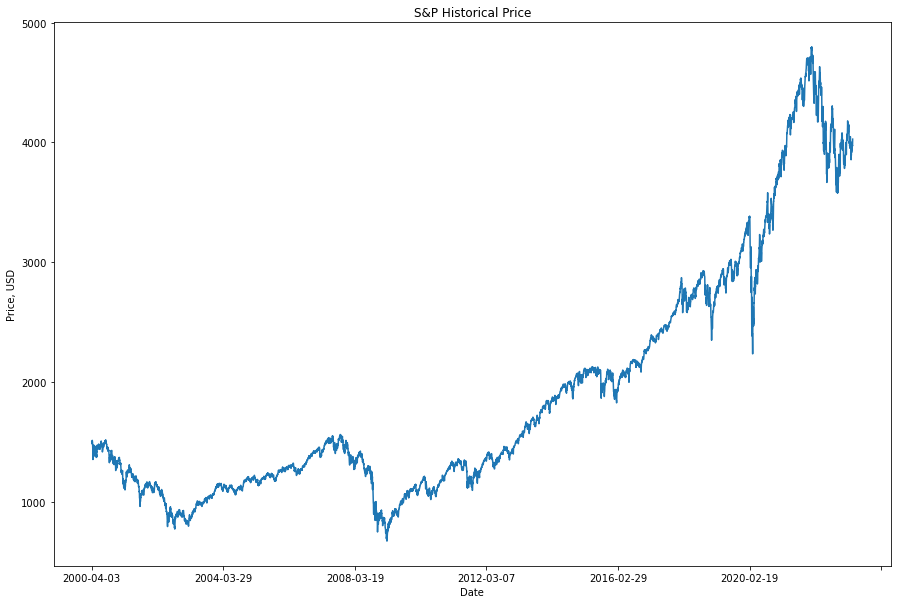

In [7]:
import matplotlib.pyplot as plt
data.set_index('date')['indexPrice'].plot(figsize = (15,10))
plt.title('S&P Historical Price')
plt.ylabel('Price, USD')
plt.xlabel('Date')


### Plot Betas for comparison

With the goal of comparing how the evolution of the betas evolved over time in different assets, Betas of AAPL, AMZN and MSFT are plotted.  
The first plot, shows how Beta evolved between 2020-01-01 until the present and the 2nd plot compares beta evolution over 2008-01-01 and 2010-01-01.

#### Since 2020

Text(0.5, 0, 'Date')

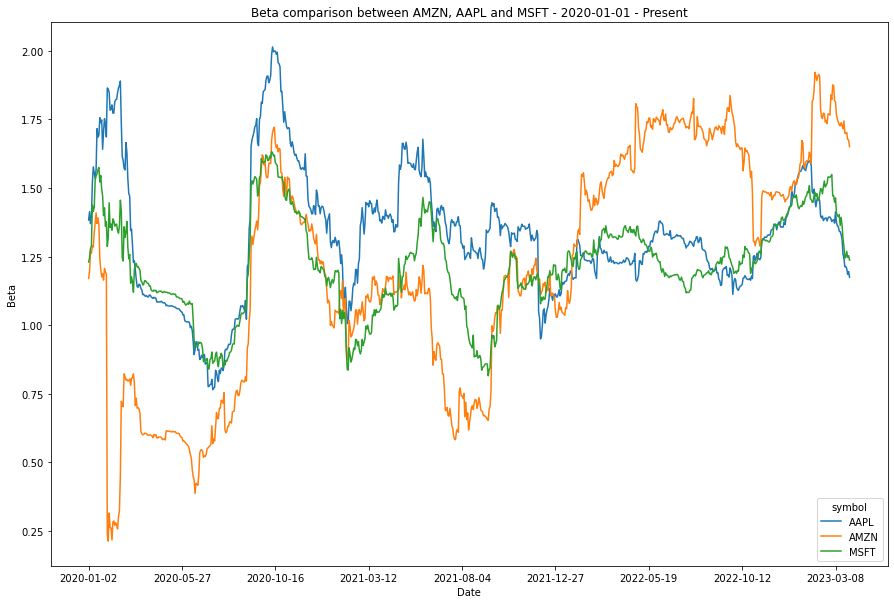

In [40]:
query = """
SELECT df.date,df.symbol, df.beta
 FROM `stockmarket-v0.stockMarket_dev.QuarterlyAlpha` as df
 where df.symbol = 'AAPL' or df.symbol='MSFT' or df.symbol='AMZN'

 """
 
project_id = 'stockmarket-v0'


df_beta = pd.read_gbq(query=query, project_id=project_id).set_index(['date','symbol']).unstack('symbol')
df_beta = df_beta.iloc[63:].droplevel(None,axis=1)

df_beta.loc[df_beta.index>'2020-01-01'].plot(figsize = (15,10))
plt.title('Beta comparison between AMZN, AAPL and MSFT - 2020-01-01 - Present')
plt.ylabel('Beta')
plt.xlabel('Date')

##### Between 2008 and 2010

Text(0.5, 0, 'Date')

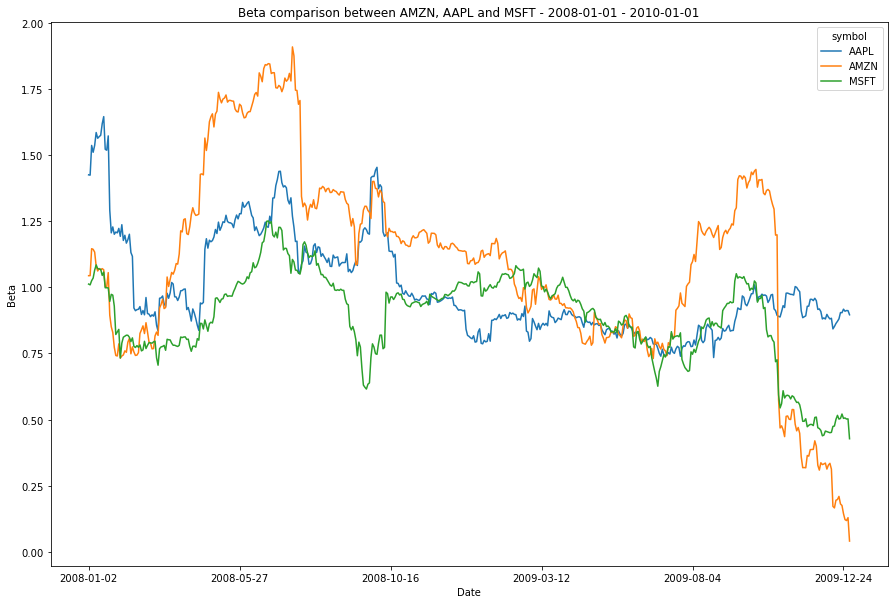

In [39]:
df_beta.loc[(df_beta.index>'2008-01-01')&(df_beta.index<'2010-01-01')].plot(figsize = (15,10))
plt.title('Beta comparison between AMZN, AAPL and MSFT - 2008-01-01 - 2010-01-01')
plt.ylabel('Beta')
plt.xlabel('Date')

### Compare Beta evolution with closing price

The following plot shows the relation between Beta and Closing price on the AAPL stock between 2020-01-01 and 2023-03-29. It's possible to see that there's a negative relation between beta and stock price meaning that stock price tends to decrease when the beta increases. This makes sense since Beta measures the amount of risk that a certain stock has compared to a benchmark. In this case, the benchmark used to calculate the beta is the S&P 500.

AAPL


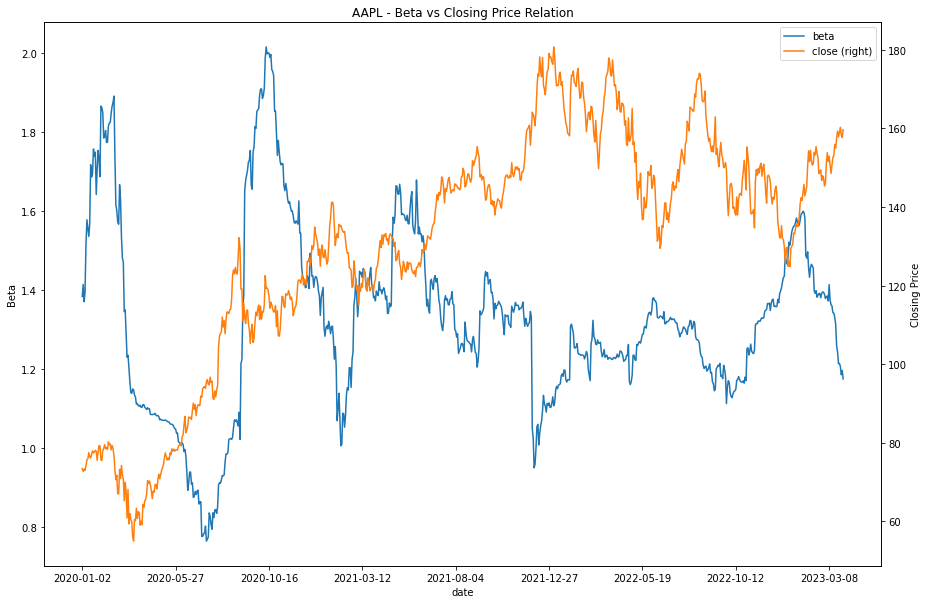

Correlation between stock price and beta: -0.06772726186989887
 
-----------------------------------------------------------------------------------------------------------------------------
 
MSFT


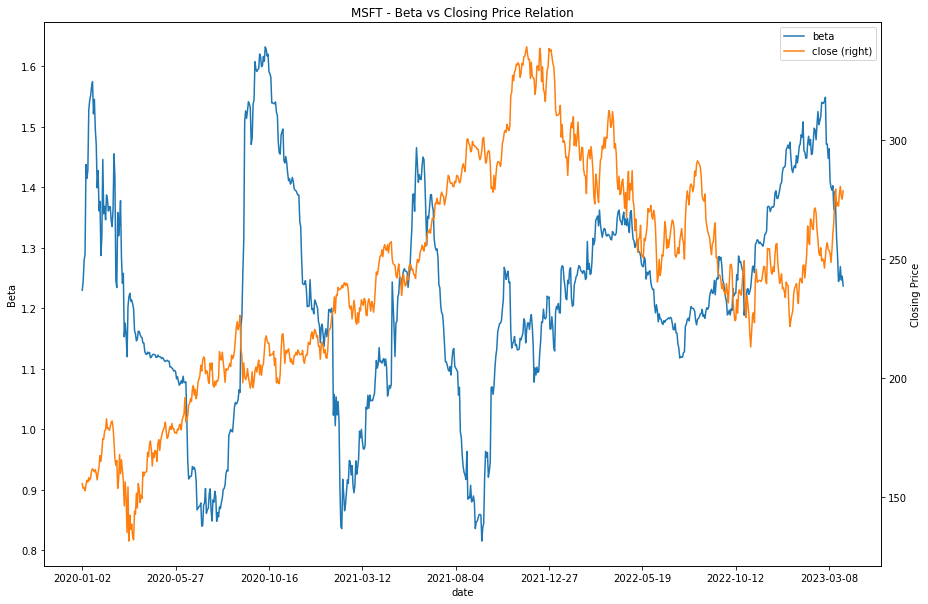

Correlation between stock price and beta: -0.06869897389208451
 
-----------------------------------------------------------------------------------------------------------------------------
 
TSLA


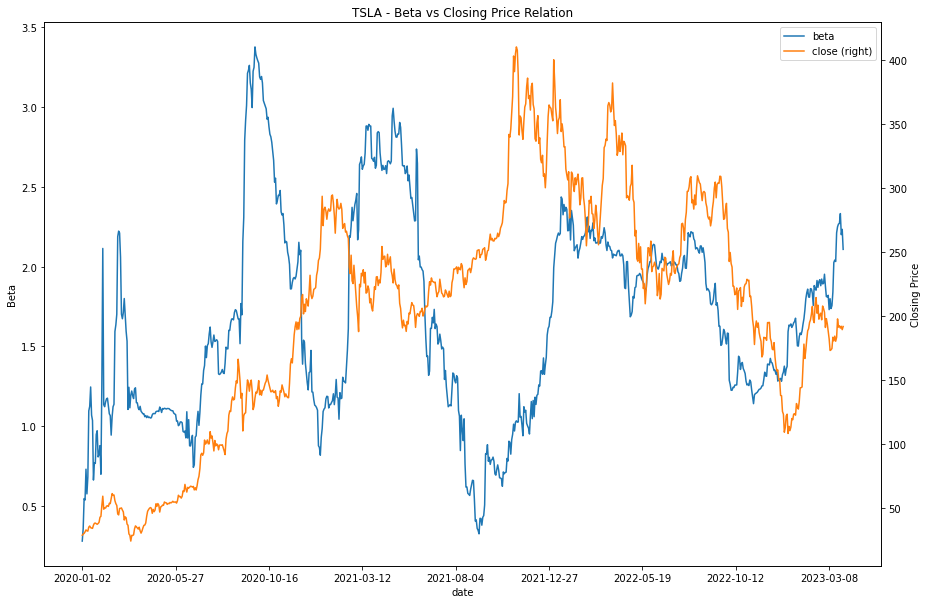

Correlation between stock price and beta: 0.1664595618148659
 
-----------------------------------------------------------------------------------------------------------------------------
 
AMZN


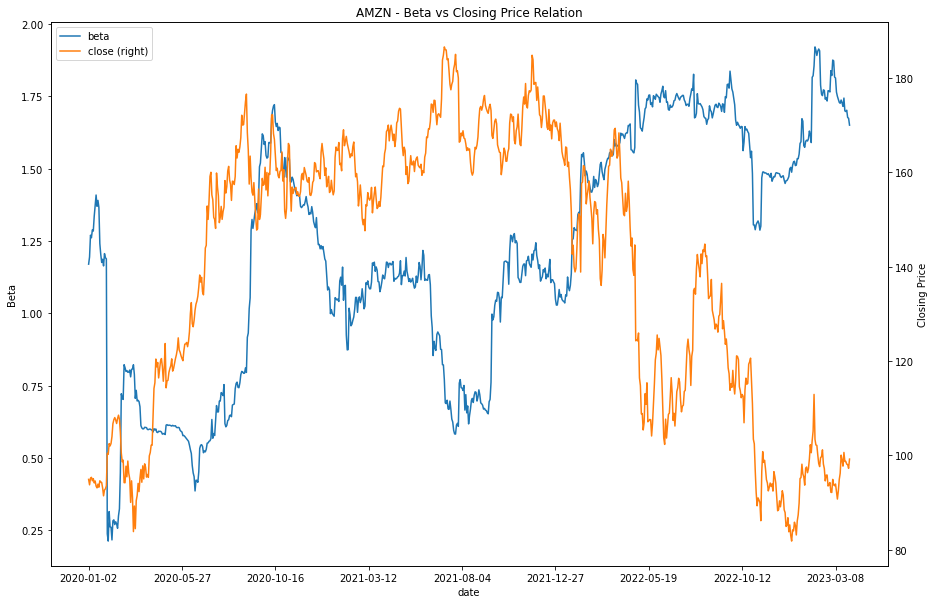

Correlation between stock price and beta: -0.2589834701193876
 
-----------------------------------------------------------------------------------------------------------------------------
 


In [104]:
ticker_list = ['AAPL','MSFT','TSLA','AMZN']
for ticker in ticker_list:
    
    query = f"""
    SELECT df.date,df.symbol, df.beta, df.close
    FROM `stockmarket-v0.stockMarket_dev.QuarterlyAlpha` as df
    where  df.symbol='{ticker}'

    """
    
    project_id = 'stockmarket-v0'

    print(ticker)
    df_beta_ = pd.read_gbq(query=query, project_id=project_id).set_index(['date','symbol']).dropna()
    df_beta_ = df_beta_.sort_values('date').droplevel('symbol')

    df_beta_ = df_beta_.loc[df_beta_.index.get_level_values(0)>'2020-01-01']
    df_beta_['beta'].plot(figsize = (15,10), legend='Beta')
    plt.ylabel('Beta')
    df_beta_['close'].plot(secondary_y=True, legend=['Close'])
    plt.ylabel('Closing Price')
    plt.xlabel('Date')
    plt.title(f'{ticker} - Beta vs Closing Price Relation')
    plt.show()

    corr_ = df_beta_.corr().iloc[1,0]

    print(f'Correlation between stock price and beta: {corr_}')
    
    print(' ')
    print('-'*125)
    print(' ')